In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm

In [ ]:
# 데이터 로드
df = pd.read_csv('/content/drive/MyDrive/통계데이터사이언스/lending_club/preprocessed_data_ver.2.2.(IRR+LOG+BINARY).csv')

In [ ]:
# 모든 열 다 보기
pd.set_option('display.max_columns', None)

# 모든 행 다 보기
pd.set_option('display.max_rows', None)

# 열 너비 넉넉하게
pd.set_option('display.width', None)

# 열 안의 값 자르지 않게
pd.set_option('display.max_colwidth', None)

In [ ]:
df.head()

,funded_amnt,term,installment,emp_length,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,recoveries,collection_recovery_fee,last_pymnt_d,last_fico_range_high,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,default,addr_state_AK,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,addr_state_nan,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan,emp_length_missing,percent_bc_gt_75_missing,funded_amnt_missing,delinq_amnt_missing,inq_last_12m_missing,fico_range_low_missing,mths_since_last_delinq_missing,all_util_missing,collection_recovery_fee_missing,fico_range_high_missing,open_act_il_missing,mths_since_recent_revol_delinq_missing,delinq_2yrs_missing,annual_inc_missing,pub_rec_missing,open_acc_6m_missing,recoveries_missing,total_acc_missing,mths_since_recent_inq_missing,open_acc_missing,last_fico_range_high_missing,mths_since_rcnt_il_missing,open_rv_24m_missing,revol_bal_missing,total_bal_il_missing,inq_last_6mths_missing,open_il_12m_missing,max_bal_bc_missing,il_util_missing,acc_now_delinq_missing,installment_missing,open_il_24m_missing,open_rv_12m_missing
0,6000.0,36,187.94,2.0,10.714440,2.269028,1,755.0,759.0,0.0,22.0,14.0,0,8.036250,14.0,36.0,0.00,0.000,Apr-2020,764.0,0,0,0,50054.0,1.0,10.0,3.0,3.0,3.0,46964.0,83.0,1.0,1.0,8.036250,64.0,10.003378,2.0,4.0,8.256088,9.385218,20.6,0,0.0,147.0,135.0,12.0,3.0,1.0,56.0,3.0,0.0,0.0,1.0,1.0,4.0,28.0,4.0,7.0,1.0,14.0,0,0,0,4.0,97.1,0.0,0,0,11.272280,10.820878,9.615872,10.942208,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,23200.0,60,680.82,10.0,11.608245,3.575151,1,670.0,674.0,1.0,10.0,24.0,0,9.735660,55.9,60.0,5260.00,946.800,Dec-2016,639.0,0,0,0,606327.0,1.0,10.0,1.0,2.0,10.0,277552.0,90.0,4.0,6.0,8.455105,85.0,10.317450,7.0,8.0,10.137175,8.702012,70.4,0,0.0,126.0,277.0,6.0,6.0,2.0,7.0,0.0,10.0,0.0,10.0,8.0,14.0,36.0,12.0,22.0,10.0,24.0,0,0,0,5.0,94.8,37.5,0,0,13.386134,12.592905,9.918425,12.582679,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm import tqdm
import numpy as np
import pandas as pd

# 드롭할 컬럼
drop_cols = [
    'term', 'last_pymnt_d', 'installment', 'funded_amnt',
    'recoveries', 'collection_recovery_fee', 'default'
]

X = df.drop(columns=drop_cols)
y = df['default']

# 결과 저장용 리스트
val_auc_list, val_acc_list = [], []
test_auc_list, test_acc_list = [], []
pred_dfs = []

# 10회 반복
for seed in tqdm(range(10), desc="Random Forest 10회 반복"):

    # 1차 분할: train 60%, val+test 40%
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, stratify=y, random_state=seed)

    # 2차 분할: val 20%, test 20% (즉, 0.5:0.5 비율로 40% 쪼개기)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=seed)

    # 모델 학습
    # 수정 : class_weight를 추가하면서 데이터 불균형 고려
    model = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight='balanced', random_state=seed)
    model.fit(X_train, y_train)

    # 검증 예측
    y_val_prob = model.predict_proba(X_val)[:, 1]
    y_val_pred = model.predict(X_val)

    val_auc_list.append(roc_auc_score(y_val, y_val_prob))
    val_acc_list.append(accuracy_score(y_val, y_val_pred))

    # 테스트 예측
    y_test_prob = model.predict_proba(X_test)[:, 1]
    y_test_pred = model.predict(X_test)

    test_auc_list.append(roc_auc_score(y_test, y_test_prob))
    test_acc_list.append(accuracy_score(y_test, y_test_pred))

    # 예측 결과 저장
    pred_df = X_test.copy()
    pred_df['default'] = y_test.values
    pred_df['original_index'] = X_test.index
    pred_df['pred_prob'] = y_test_prob
    pred_df['pred'] = y_test_pred
    pred_dfs.append(pred_df)

# 결과 출력
print("\n검증 성능 요약")
print(f"Val AUC 평균: {np.mean(val_auc_list):.4f} ± {np.std(val_auc_list):.4f}")
print(f"Val ACC 평균: {np.mean(val_acc_list):.4f} ± {np.std(val_acc_list):.4f}")

print("\n테스트 성능 요약")
print(f"Test AUC 평균: {np.mean(test_auc_list):.4f} ± {np.std(test_auc_list):.4f}")
print(f"Test ACC 평균: {np.mean(test_acc_list):.4f} ± {np.std(test_acc_list):.4f}")


Random Forest 10회 반복: 100%|██████████| 10/10 [16:31<00:00, 99.14s/it]


검증 성능 요약
Val AUC 평균: 0.9300 ± 0.0007
Val ACC 평균: 0.8819 ± 0.0013

테스트 성능 요약
Test AUC 평균: 0.9301 ± 0.0007
Test ACC 평균: 0.8822 ± 0.0010


In [ ]:
pred_all = pd.concat(pred_dfs, ignore_index=True)

cols_needed = ['term', 'installment', 'funded_amnt', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d']
pred_all = pred_all.merge(
    df[cols_needed],
    left_on='original_index',  # ← pred_all 안에 있는 열
    right_index=True,          # ← df의 인덱스
    how='left'
)


In [ ]:
check = df.loc[pred_all['original_index'], 'funded_amnt'].reset_index(drop=True) == pred_all['funded_amnt']
print("값이 일치하는 행 비율:", check.mean())  # 1.0이면 완벽히 일치


값이 일치하는 행 비율: 1.0


In [ ]:
!pip install fredapi

In [ ]:
import os

os.environ["FRED_API_KEY"] = "05ceea53cbc890aa3e4416729c89001b"

In [ ]:
from fredapi import Fred
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import os

# 1. FRED API 연결
def connect_fred_api():
    return Fred(api_key=os.getenv("FRED_API_KEY"))  # 환경변수에서 API 키 불러오기

# 2. 3년/5년 금리 시계열 불러오기
def load_risk_free_series():
    fred = connect_fred_api()
    rate_series_3y = fred.get_series('GS3')
    rate_series_5y = fred.get_series('GS5')
    return rate_series_3y, rate_series_5y

# 3. last_pymnt_d와 term으로 issue_d 추정
def estimate_issue_d(last_pymnt_d, term):
    if pd.isnull(last_pymnt_d) or pd.isnull(term):
        return np.nan
    try:
        last_date = pd.to_datetime(last_pymnt_d)
        return last_date - relativedelta(months=int(term))
    except:
        return np.nan

# 4. 추정된 날짜에 가장 가까운 금리 적용
def fetch_risk_free_rate(estimated_issue_d, term, rate_series_3y, rate_series_5y):
    if pd.isnull(estimated_issue_d) or pd.isnull(term):
        return np.nan

    if term == 36:
        target_series = rate_series_3y
    elif term == 60:
        target_series = rate_series_5y
    else:
        return np.nan

    try:
        idx = target_series.index.get_indexer([estimated_issue_d], method='nearest')[0]
        return target_series.iloc[idx] / 100
    except Exception as e:
        print(f"Error fetching rate for {estimated_issue_d}: {e}")
        return np.nan

# 5. 전체 데이터프레임에 적용
def apply_estimated_risk_free_rate(df):
    rate_series_3y, rate_series_5y = load_risk_free_series()

    # issue_d 추정
    df['estimated_issue_d'] = df.apply(lambda x: estimate_issue_d(x['last_pymnt_d'], x['term']), axis=1)

    # 금리 적용
    df['risk_free_rate'] = df.apply(
        lambda x: fetch_risk_free_rate(x['estimated_issue_d'], x['term'], rate_series_3y, rate_series_5y),
        axis=1
    )

    return df


In [ ]:
# 금리 시계열 불러오기
rate_series_3y, rate_series_5y = load_risk_free_series()

# estimated_issue_d 컬럼 생성 (last_pymnt_d와 term 기반)
pred_all['estimated_issue_d'] = pred_all.apply(
    lambda x: estimate_issue_d(x['last_pymnt_d'], x['term']),
    axis=1
)


In [ ]:
# recoveries / funded_amnt가 1을 초과하는 이상치 제거
pred_all = pred_all[(pred_all['recoveries'] / pred_all['funded_amnt']) <= 1.0]


In [ ]:
# 추정된 issue_d로부터 금리 시계열 적용
pred_all = apply_estimated_risk_free_rate(pred_all)

In [ ]:
def calculate_last_pymnt_num(row):
    try:
        last_date = pd.to_datetime(row['last_pymnt_d'])
        issue_d = row.get('estimated_issue_d') or row.get('issue_d')  # estimated_issue_d 우선
        if pd.isnull(issue_d):
            return np.nan
        issue_date = pd.to_datetime(issue_d)
        delta = (last_date.year - issue_date.year) * 12 + (last_date.month - issue_date.month)
        return max(delta, 0)
    except:
        return np.nan


In [ ]:
# 적용
pred_all['last_pymnt_num'] = pred_all.apply(calculate_last_pymnt_num, axis=1)


In [ ]:
# 현금흐름 계산 함수
def create_cash_flow(row):
    loan_amnt = row['funded_amnt']  # funded_amnt 사용
    installment = row['installment']
    term = int(row['term'])
    default = row['default']
    last_pymnt_num = row['last_pymnt_num']
    recoveries = row['recoveries']
    collection_recovery_fee = row['collection_recovery_fee']

    # 기본 현금 흐름 시작: 대출금 지출
    cash_flow = [-loan_amnt]
    for month in range(1, term + 1):
        if default == 1:
            if month == last_pymnt_num + 1:
                cash_flow.append(recoveries - collection_recovery_fee)
            elif month <= last_pymnt_num:
                cash_flow.append(installment)
            else:
                cash_flow.append(0)
        else:
            cash_flow.append(installment)

    return cash_flow


# 2. 캐시 저장 및 계산 함수
cash_flow_cache = {}

def get_cash_flow(row):
    # 필수 컬럼들
    required_cols = ['funded_amnt', 'installment', 'term', 'default',
                     'last_pymnt_num', 'recoveries', 'collection_recovery_fee']

    # 필수 값 누락 시 NaN 반환
    if row[required_cols].isnull().any():
        return np.nan

    try:
        key = (
            float(row['funded_amnt']),
            float(row['installment']),
            int(row['term']),
            int(row['default']),
            int(row['last_pymnt_num']),
            float(row['recoveries']),
            float(row['collection_recovery_fee'])
        )
    except Exception as e:
        print(f"[캐시 키 생성 오류] index={row.name} ▶ {e}")
        return np.nan

    if key not in cash_flow_cache:
        cash_flow_cache[key] = create_cash_flow(row)

    return cash_flow_cache[key]


In [ ]:
# 캐시 플로우 계산 적용
pred_all['cash_flow'] = pred_all.apply(get_cash_flow, axis=1)


In [ ]:
!pip install numpy-financial

In [ ]:
import numpy as np
import numpy_financial as npf

# IRR 함수 정의
def calculate_irr(cash_flow):
    irr_monthly = npf.irr(cash_flow)
    if irr_monthly is not None and not np.isnan(irr_monthly):
        return (1 + irr_monthly) ** 12 - 1
    else:
        return np.nan

# 캐시 기반 IRR
irr_cache = {}
def get_irr(cash_flow):
    if not isinstance(cash_flow, list) or len(cash_flow) == 0:
        return np.nan
    key = tuple(round(v, 6) for v in cash_flow)
    if key not in irr_cache:
        irr_cache[key] = calculate_irr(cash_flow)
    return irr_cache[key]

# 적용
pred_all['irr'] = pred_all['cash_flow'].apply(get_irr)

# IRR 누락된 경우는 risk-free rate로 대체
pred_all['irr'] = pred_all['irr'].fillna(pred_all['risk_free_rate'])


In [ ]:
def calculate_sharpe(returns, risk_free):
    returns = np.asarray(returns, dtype=float)
    risk_free = np.asarray(risk_free, dtype=float)
    mask = ~np.isnan(returns) & ~np.isnan(risk_free)
    excess = returns[mask] - risk_free[mask]
    if excess.size == 0 or np.nanstd(returns, ddof=1) == 0:
        return np.nan
    return np.nanmean(excess) / np.nanstd(excess, ddof=1)

def compute_sharpe_for_threshold(df, threshold):
    selected = df[df['pred_prob'] <= threshold]
    return calculate_sharpe(selected['irr'], selected['risk_free_rate'])

def find_best_threshold(df, thresholds=np.arange(0.1, 1.01, 0.01)):
    results = []
    for t in thresholds:
        sr = compute_sharpe_for_threshold(df, t)
        results.append((t, sr))
    results = sorted(results, key=lambda x: -x[1] if not np.isnan(x[1]) else -np.inf)
    best_t, best_sr = results[0]
    return best_t, best_sr, results


In [ ]:
sharpe = calculate_sharpe(pred_all['irr'], pred_all['risk_free_rate'])
print(f"전체 Sharpe Ratio: {sharpe:.4f}")


전체 Sharpe Ratio: 2.3765


In [ ]:
def compute_sharpe_for_threshold(df, threshold):
    selected = df[df['pred_prob'] <= threshold]
    return calculate_sharpe(selected['irr'], selected['risk_free_rate'])

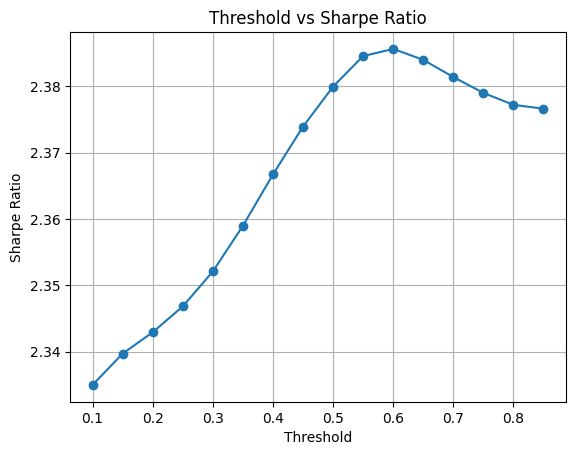

In [ ]:
import matplotlib.pyplot as plt

thresholds = np.arange(0.1, 0.9, 0.05)
sharpe_list = [compute_sharpe_for_threshold(pred_all, th) for th in thresholds]

plt.plot(thresholds, sharpe_list, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Sharpe Ratio')
plt.title('Threshold vs Sharpe Ratio')
plt.ticklabel_format(useOffset=False)
plt.grid(True)
plt.show()

In [ ]:
# threshold 값 리스트
thresholds = np.arange(0.1, 0.9, 0.05)

# threshold별 sharpe ratio 계산
sharpe_values = [compute_sharpe_for_threshold(pred_all, t) for t in thresholds]

# 가장 높은 Sharpe Ratio와 해당 threshold 찾기
max_idx = np.nanargmax(sharpe_values)
best_threshold = thresholds[max_idx]
best_sharpe = sharpe_values[max_idx]

print(f"최적 Threshold: {best_threshold:.2f}")
print(f"최대 Sharpe Ratio: {best_sharpe:.4f}")


최적 Threshold: 0.60
최대 Sharpe Ratio: 2.3856


In [ ]:
subset = pred_all[pred_all['pred_prob'] <= 0.7]
print("Subset 샘플 수:", len(subset))
print("Sharpe Ratio:", calculate_sharpe(subset['irr'], subset['risk_free_rate']))
print("IRR 평균:", subset['irr'].mean())
print("IRR 표준편차:", subset['irr'].std())


Subset 샘플 수: 2174049
Sharpe Ratio: 2.381385002326837
IRR 평균: 0.14011619111708623
IRR 표준편차: 0.05495640405565388


In [ ]:
pred_all['risk_free_rate'].describe()


,risk_free_rate
count,2.228229e+06
mean,1.041419e-02
std,4.637308e-03
min,3.300000e-03
25%,7.900000e-03
50%,9.700000e-03
75%,1.280000e-02
max,5.090000e-02


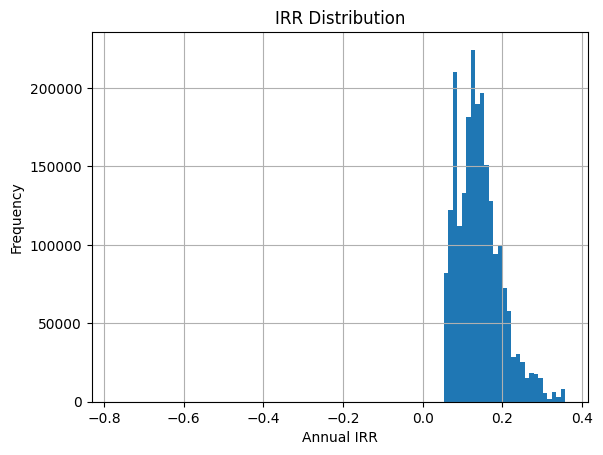

In [ ]:
import matplotlib.pyplot as plt
pred_all['irr'].hist(bins=100)
plt.title("IRR Distribution")
plt.xlabel("Annual IRR")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()




---



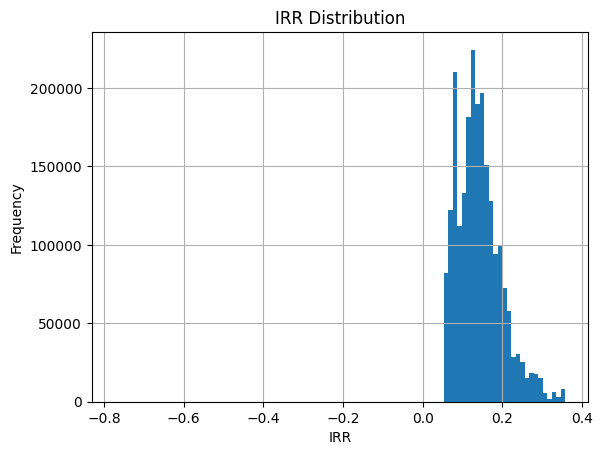

In [ ]:
import matplotlib.pyplot as plt

# IRR 분포 시각화
plt.hist(pred_all['irr'], bins=100)
plt.title('IRR Distribution')
plt.xlabel('IRR')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
pred_all['irr'].sort_values(ascending=False).head(20)


,irr
197861,0.358041
1938976,0.357994
1518744,0.357986
1874246,0.357986
214264,0.357986
1976284,0.357985
1367767,0.357985
539225,0.357985
1687835,0.357985
289894,0.357985


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/

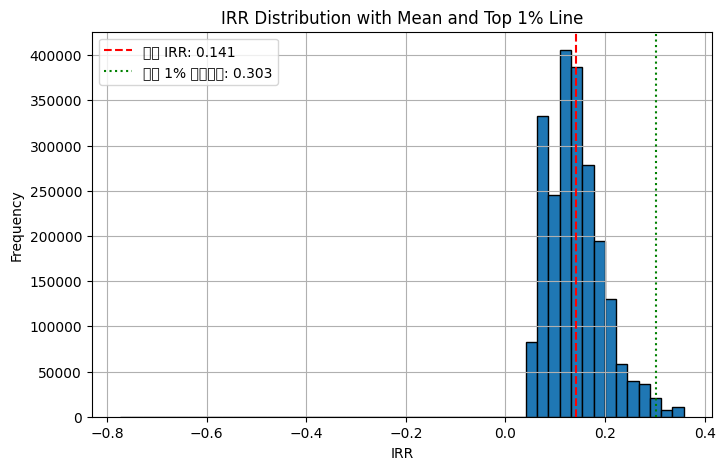

In [ ]:
import matplotlib.pyplot as plt

# IRR 데이터
irr_values = pred_all['irr'].dropna()

# 평균 및 커트라인 계산
mean_irr = irr_values.mean()
top1_cutoff = irr_values.quantile(0.99)

# 시각화
plt.figure(figsize=(8, 5))
plt.hist(irr_values, bins=50, edgecolor='black')
plt.axvline(mean_irr, color='red', linestyle='--', label=f'평균 IRR: {mean_irr:.3f}')
plt.axvline(top1_cutoff, color='green', linestyle=':', label=f'상위 1% 커트라인: {top1_cutoff:.3f}')
plt.title('IRR Distribution with Mean and Top 1% Line')
plt.xlabel('IRR')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
pred_all['last_pymnt_num'].describe()


,last_pymnt_num
count,2.228229e+06
mean,4.201862e+01
std,1.040304e+01
min,3.600000e+01
25%,3.600000e+01
50%,3.600000e+01
75%,6.000000e+01
max,6.000000e+01


In [ ]:
# 1. 비정상적으로 높은 IRR을 갖는 row 확인
pred_all[pred_all['irr'] > 0.3].sample(10)

# 2. recoveries 비율
(pred_all['recoveries'] / pred_all['funded_amnt']).describe()

# 3. cash_flow가 어떻게 생겼는지 실제 예시
pred_all.loc[pred_all['irr'] > 0.3, 'cash_flow'].values[:5]


array([list([-25000.0, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43, 767.43]),
       list([-31325.0, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 977.98, 

In [ ]:
(pred_all['recoveries'] / pred_all['funded_amnt']).describe()


,0
count,2.232320e+06
mean,1.633060e-02
std,5.571283e-02
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,2.170300e+00
